In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Enable inline plots
%matplotlib inline

In [2]:
# Load the provided JSON files
files = [
    "dev_tables.json",
    "dev.json",
    "dev_tied_append.json"
]

# Read and parse the JSON files
data = {file: json.load(open(file, 'r')) for file in files}

# Extract data for analysis
# dev_tables.json: Information about tables in databases
dev_tables = pd.json_normalize(data["dev_tables.json"])

# dev.json: Question-SQL pairs and related metadata
dev = pd.DataFrame(data["dev.json"])

# dev_tied_append.json: Extended question-SQL pairs and metadata
dev_tied_append = pd.DataFrame(data["dev_tied_append.json"])

# Summary of the data structures
summary = {
    "dev_tables": {
        "columns": dev_tables.columns.tolist(),
        "row_count": len(dev_tables),
    },
    "dev": {
        "columns": dev.columns.tolist(),
        "row_count": len(dev),
    },
    "dev_tied_append": {
        "columns": dev_tied_append.columns.tolist(),
        "row_count": len(dev_tied_append),
    }
}

# Inspect the structure and row count of each dataset
summary

{'dev_tables': {'columns': ['db_id',
   'table_names_original',
   'table_names',
   'column_names_original',
   'column_names',
   'column_types',
   'primary_keys',
   'foreign_keys'],
  'row_count': 11},
 'dev': {'columns': ['question_id',
   'db_id',
   'question',
   'evidence',
   'SQL',
   'difficulty'],
  'row_count': 1534},
 'dev_tied_append': {'columns': ['question_id',
   'db_id',
   'question',
   'evidence',
   'SQL',
   'difficulty'],
  'row_count': 42}}

In [3]:
# Count the number of tables, columns, primary keys, and foreign keys per database
schema_analysis = dev_tables[["db_id", "table_names", "column_names", "primary_keys", "foreign_keys"]].copy()
schema_analysis["num_tables"] = schema_analysis["table_names"].apply(len)
schema_analysis["num_columns"] = schema_analysis["column_names"].apply(len)
schema_analysis["num_primary_keys"] = schema_analysis["primary_keys"].apply(len)
schema_analysis["num_foreign_keys"] = schema_analysis["foreign_keys"].apply(len)

# Summarize the schema complexity
schema_summary = schema_analysis[["num_tables", "num_columns", "num_primary_keys", "num_foreign_keys"]].describe()

schema_summary

,num_tables,num_columns,num_primary_keys,num_foreign_keys
count,11.000000,11.000000,11.000000,11.000000
mean,6.818182,73.545455,6.545455,9.272727
std,3.060006,52.612477,3.045115,8.509887
min,3.000000,12.000000,2.000000,1.000000
25%,4.500000,40.500000,4.500000,3.000000
50%,7.000000,65.000000,7.000000,8.000000
75%,8.000000,92.500000,8.000000,12.000000
max,13.000000,200.000000,13.000000,29.000000


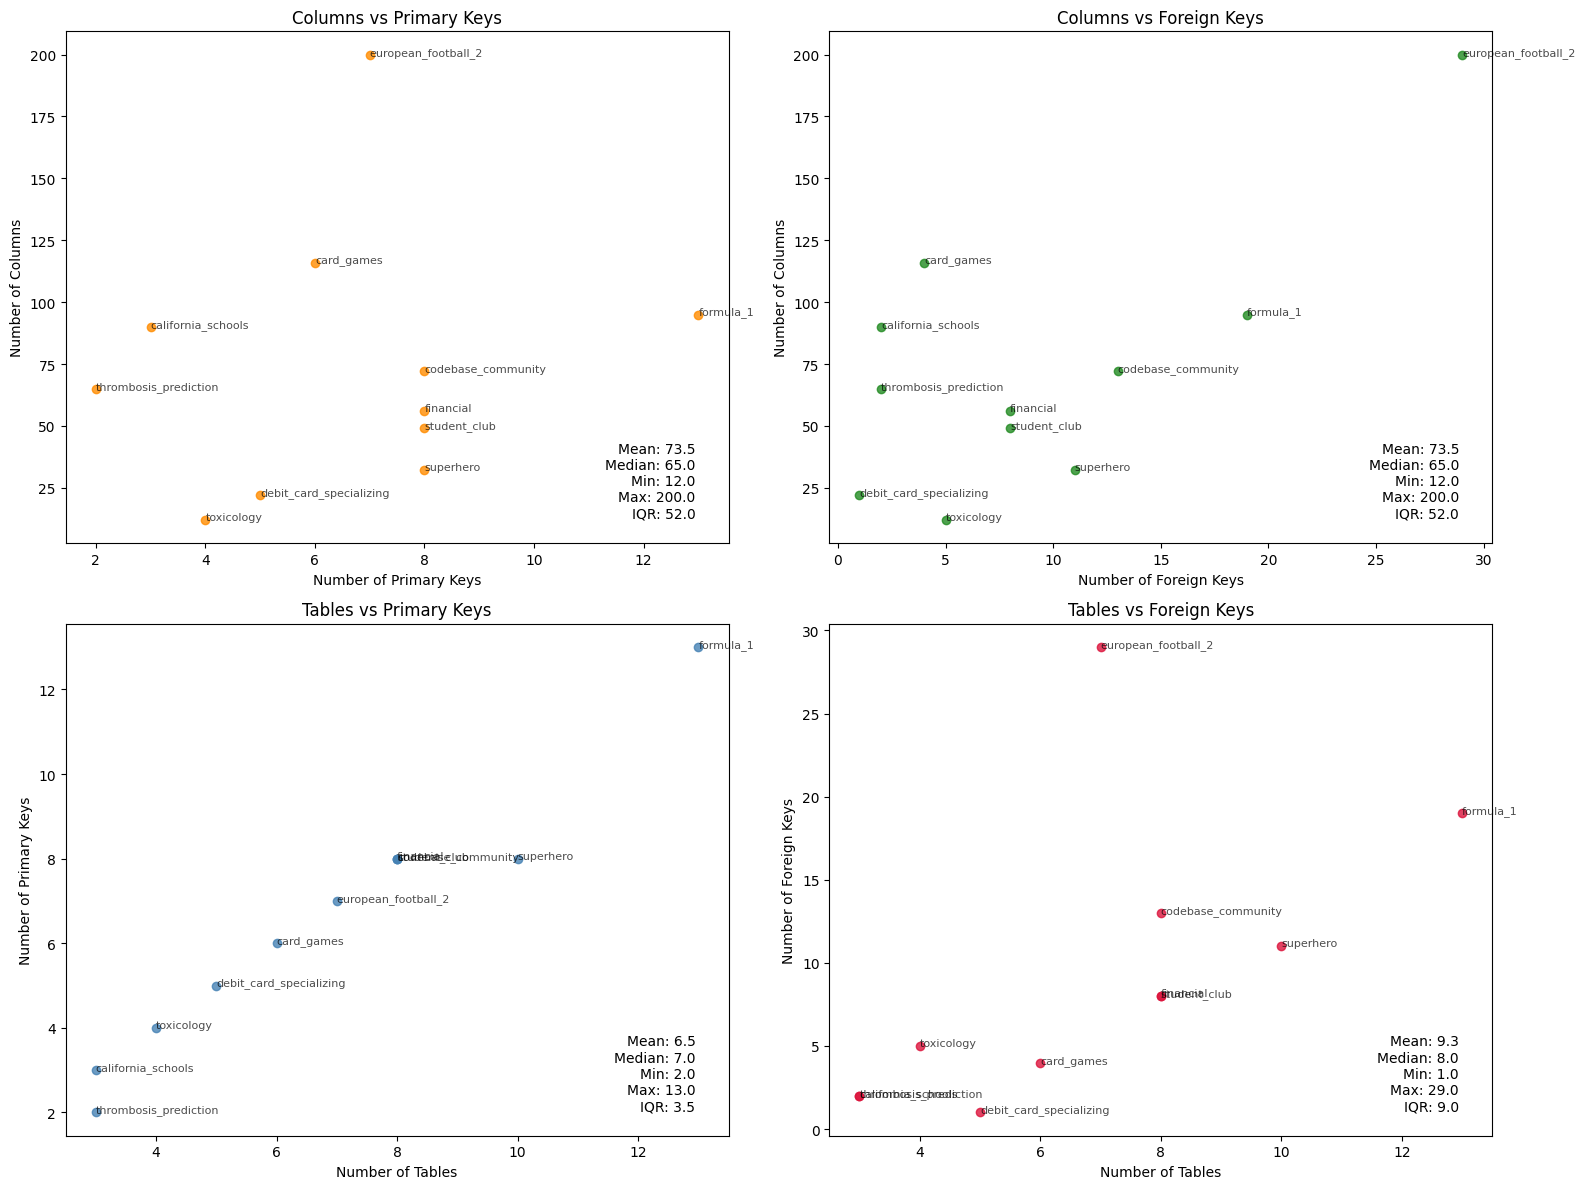

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Scatter plot: Columns vs Primary Keys
axes[0, 0].scatter(schema_analysis["num_primary_keys"], schema_analysis["num_columns"], color='darkorange', alpha=0.8)
for i, db_id in enumerate(schema_analysis["db_id"]):
    axes[0, 0].annotate(db_id, (schema_analysis["num_primary_keys"].iloc[i], schema_analysis["num_columns"].iloc[i]), fontsize=8, alpha=0.7)
axes[0, 0].set_title("Columns vs Primary Keys")
axes[0, 0].set_xlabel("Number of Primary Keys")
axes[0, 0].set_ylabel("Number of Columns")

# Scatter plot: Columns vs Foreign Keys
axes[0, 1].scatter(schema_analysis["num_foreign_keys"], schema_analysis["num_columns"], color='forestgreen', alpha=0.8)
for i, db_id in enumerate(schema_analysis["db_id"]):
    axes[0, 1].annotate(db_id, (schema_analysis["num_foreign_keys"].iloc[i], schema_analysis["num_columns"].iloc[i]), fontsize=8, alpha=0.7)
axes[0, 1].set_title("Columns vs Foreign Keys")
axes[0, 1].set_xlabel("Number of Foreign Keys")
axes[0, 1].set_ylabel("Number of Columns")

# Scatter plot: Tables vs Primary Keys
axes[1, 0].scatter(schema_analysis["num_tables"], schema_analysis["num_primary_keys"], color='steelblue', alpha=0.8)
for i, db_id in enumerate(schema_analysis["db_id"]):
    axes[1, 0].annotate(db_id, (schema_analysis["num_tables"].iloc[i], schema_analysis["num_primary_keys"].iloc[i]), fontsize=8, alpha=0.7)
axes[1, 0].set_title("Tables vs Primary Keys")
axes[1, 0].set_xlabel("Number of Tables")
axes[1, 0].set_ylabel("Number of Primary Keys")

# Scatter plot: Tables vs Foreign Keys
axes[1, 1].scatter(schema_analysis["num_tables"], schema_analysis["num_foreign_keys"], color='crimson', alpha=0.8)
for i, db_id in enumerate(schema_analysis["db_id"]):
    axes[1, 1].annotate(db_id, (schema_analysis["num_tables"].iloc[i], schema_analysis["num_foreign_keys"].iloc[i]), fontsize=8, alpha=0.7)
axes[1, 1].set_title("Tables vs Foreign Keys")
axes[1, 1].set_xlabel("Number of Tables")
axes[1, 1].set_ylabel("Number of Foreign Keys")

# Add statistical annotations for each axis (mean, median, etc.)
for ax, metric, y_label in zip(
    [axes[0, 0], axes[0, 1], axes[1, 0], axes[1, 1]],
    ["num_columns", "num_columns", "num_primary_keys", "num_foreign_keys"],
    ["Number of Columns", "Number of Columns", "Number of Primary Keys", "Number of Foreign Keys"],
):
    stats = schema_analysis[metric].describe()
    stats_text = (
        f"Mean: {stats['mean']:.1f}\n"
        f"Median: {schema_analysis[metric].median():.1f}\n"
        f"Min: {stats['min']:.1f}\n"
        f"Max: {stats['max']:.1f}\n"
        f"IQR: {stats['75%'] - stats['25%']:.1f}"
    )
    ax.annotate(stats_text, xy=(0.95, 0.05), xycoords='axes fraction', fontsize=10, ha='right', color='black')

plt.tight_layout()
plt.show()

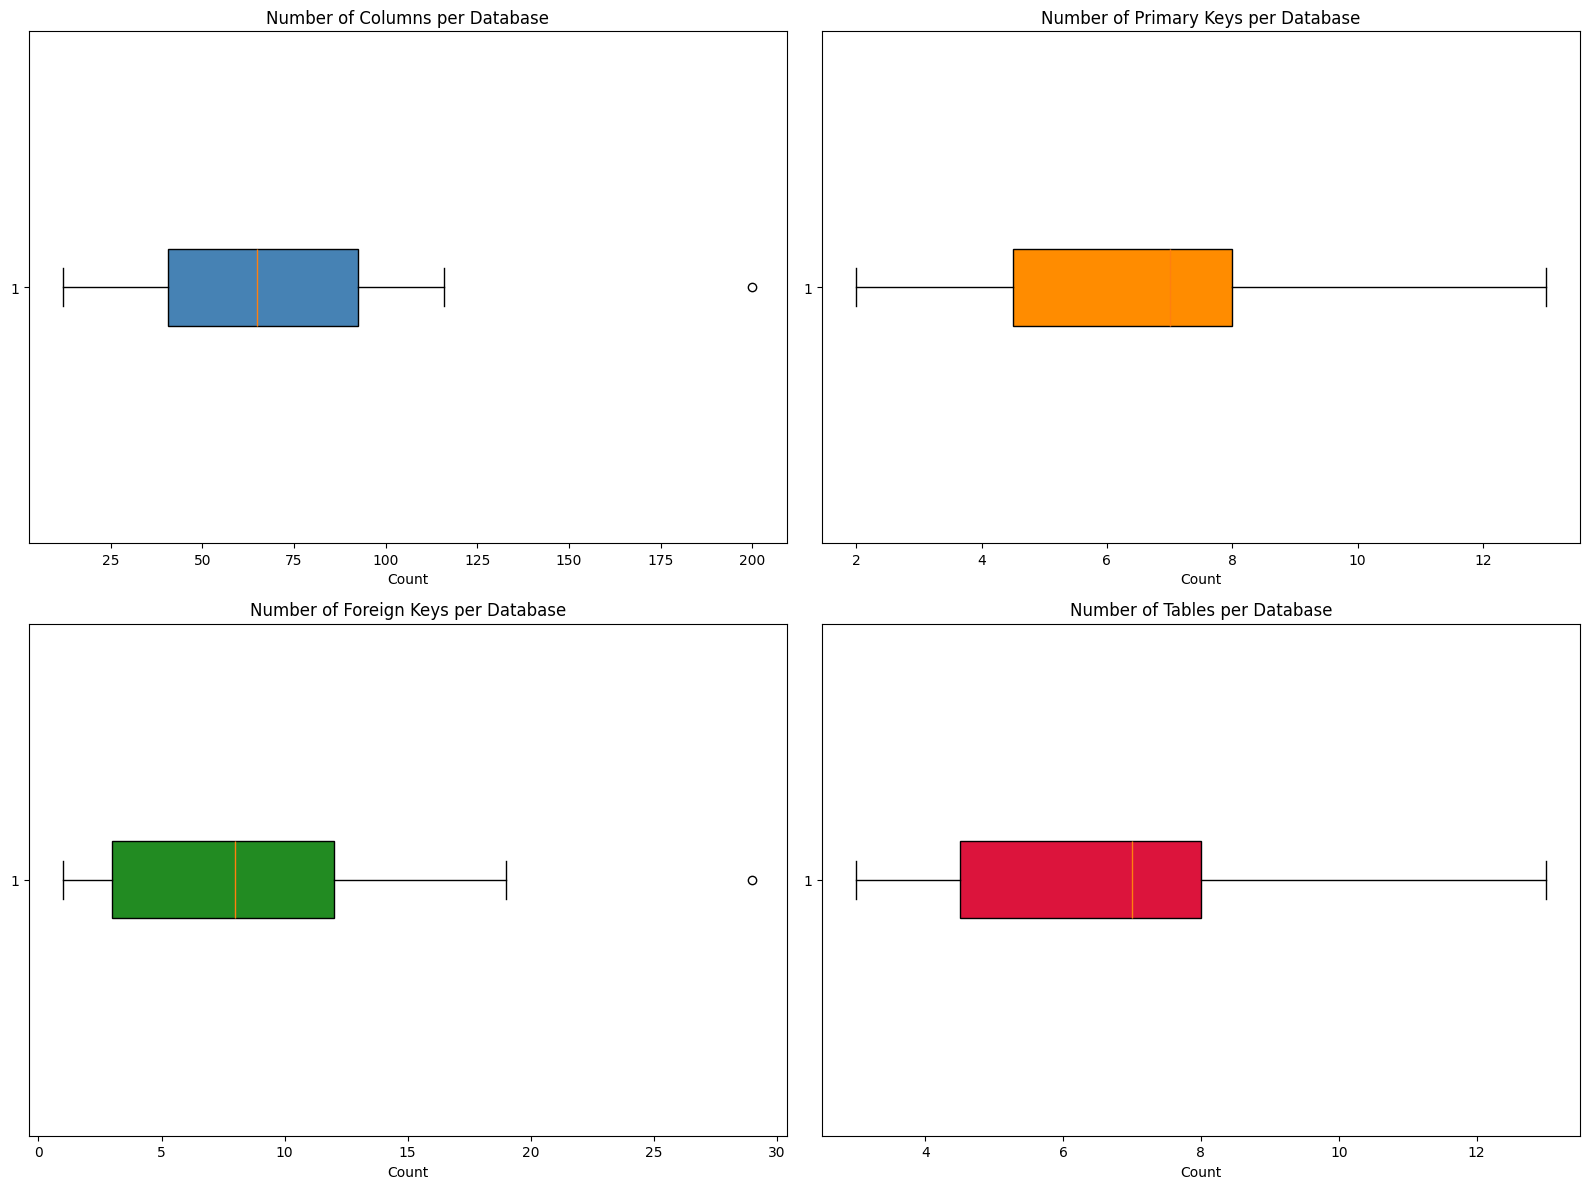

In [5]:
# Box plots to visualize statistical metrics (mean, median, min, max, and IQR) for schema components

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Box plot for Number of Columns
axes[0, 0].boxplot(schema_analysis["num_columns"], vert=False, patch_artist=True, boxprops=dict(facecolor='steelblue'))
axes[0, 0].set_title("Number of Columns per Database")
axes[0, 0].set_xlabel("Count")

# Box plot for Number of Primary Keys
axes[0, 1].boxplot(schema_analysis["num_primary_keys"], vert=False, patch_artist=True, boxprops=dict(facecolor='darkorange'))
axes[0, 1].set_title("Number of Primary Keys per Database")
axes[0, 1].set_xlabel("Count")

# Box plot for Number of Foreign Keys
axes[1, 0].boxplot(schema_analysis["num_foreign_keys"], vert=False, patch_artist=True, boxprops=dict(facecolor='forestgreen'))
axes[1, 0].set_title("Number of Foreign Keys per Database")
axes[1, 0].set_xlabel("Count")

# Box plot for Number of Tables
axes[1, 1].boxplot(schema_analysis["num_tables"], vert=False, patch_artist=True, boxprops=dict(facecolor='crimson'))
axes[1, 1].set_title("Number of Tables per Database")
axes[1, 1].set_xlabel("Count")

plt.tight_layout()
plt.show()

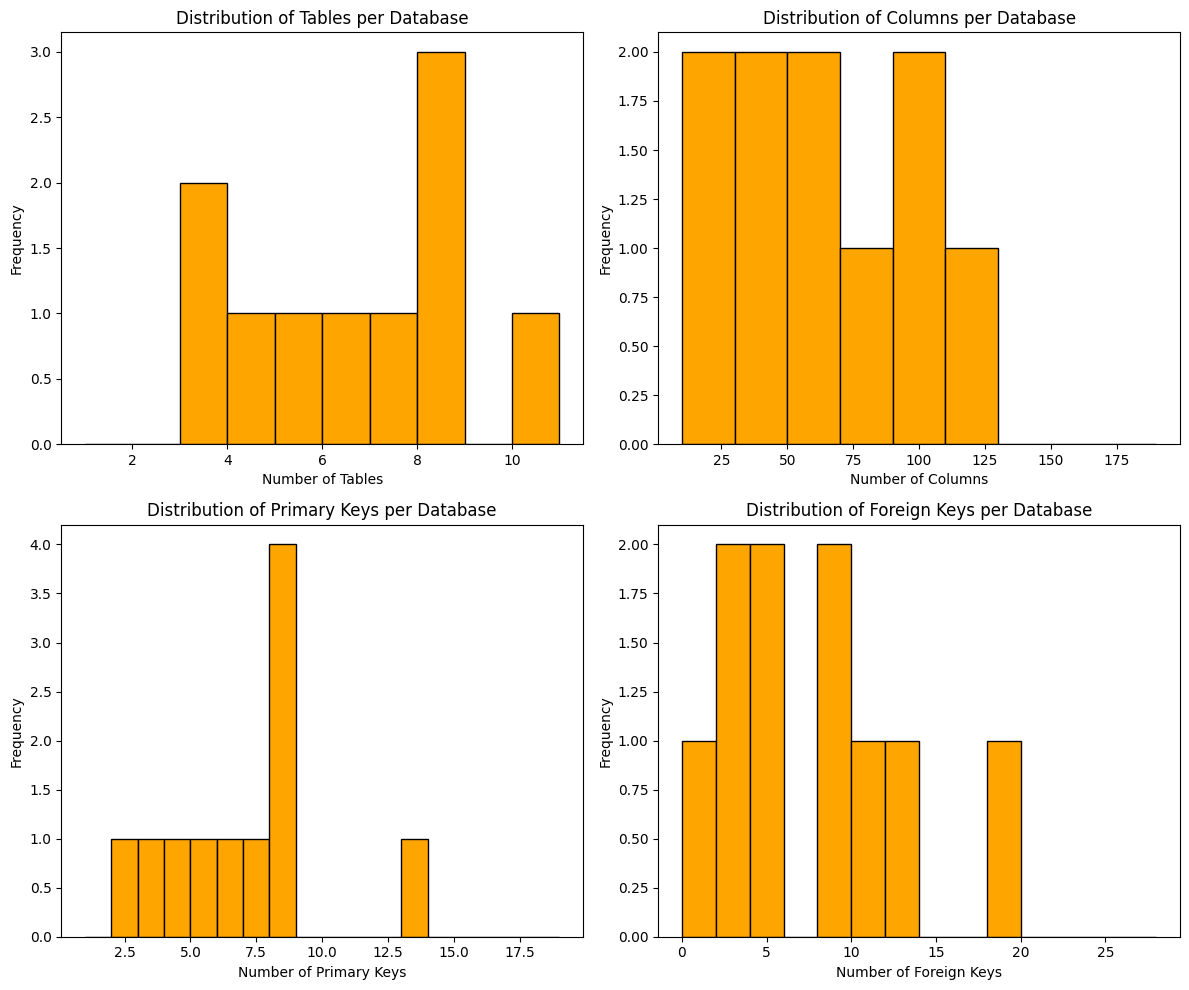

In [6]:
# Visualization: Distribution of schema complexity metrics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot the number of tables per database
axes[0, 0].hist(schema_analysis["num_tables"], bins=range(1, 12), color="orange", edgecolor="black")
axes[0, 0].set_title("Distribution of Tables per Database")
axes[0, 0].set_xlabel("Number of Tables")
axes[0, 0].set_ylabel("Frequency")

# Plot the number of columns per database
axes[0, 1].hist(schema_analysis["num_columns"], bins=range(10, 200, 20), color="orange", edgecolor="black")
axes[0, 1].set_title("Distribution of Columns per Database")
axes[0, 1].set_xlabel("Number of Columns")
axes[0, 1].set_ylabel("Frequency")

# Plot the number of primary keys per database
axes[1, 0].hist(schema_analysis["num_primary_keys"], bins=range(1, 20), color="orange", edgecolor="black")
axes[1, 0].set_title("Distribution of Primary Keys per Database")
axes[1, 0].set_xlabel("Number of Primary Keys")
axes[1, 0].set_ylabel("Frequency")

# Plot the number of foreign keys per database
axes[1, 1].hist(schema_analysis["num_foreign_keys"], bins=range(0, 30, 2), color="orange", edgecolor="black")
axes[1, 1].set_title("Distribution of Foreign Keys per Database")
axes[1, 1].set_xlabel("Number of Foreign Keys")
axes[1, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

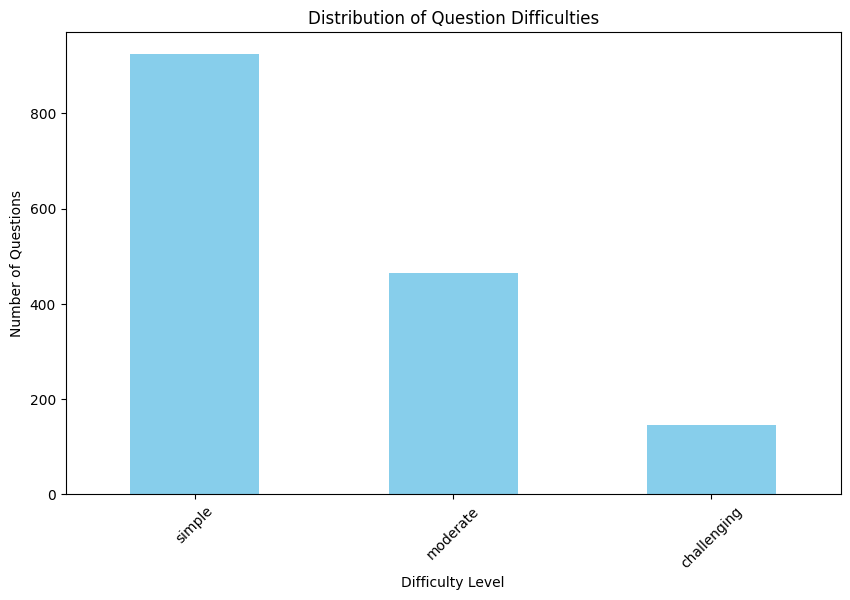

In [7]:
import matplotlib.pyplot as plt

# Count the number of questions for each difficulty level
difficulty_counts = dev['difficulty'].value_counts()

# Plot the distribution of question difficulties
plt.figure(figsize=(10, 6))
difficulty_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Question Difficulties')
plt.xlabel('Difficulty Level')
plt.ylabel('Number of Questions')
plt.xticks(rotation=45)
plt.show()

In [8]:
# Load Dataset
with open("dev.json", "r") as file:
    data = json.load(file)

# Convert JSON to DataFrame
df = pd.DataFrame(data)

df.head()

,question_id,db_id,question,evidence,SQL,difficulty
0,0,california_schools,What is the highest eligible free rate for K-1...,Eligible free rate for K-12 = `Free Meal Count...,SELECT `Free Meal Count (K-12)` / `Enrollment ...,simple
1,1,california_schools,Please list the lowest three eligible free rat...,Eligible free rates for students aged 5-17 = `...,SELECT `Free Meal Count (Ages 5-17)` / `Enroll...,moderate
2,2,california_schools,Please list the zip code of all the charter sc...,Charter schools refers to `Charter School (Y/N...,SELECT T2.Zip FROM frpm AS T1 INNER JOIN schoo...,simple
3,3,california_schools,What is the unabbreviated mailing street addre...,,SELECT T2.MailStreet FROM frpm AS T1 INNER JOI...,simple
4,4,california_schools,Please list the phone numbers of the direct ch...,Charter schools refers to `Charter School (Y/N...,SELECT T2.Phone FROM frpm AS T1 INNER JOIN sch...,moderate


In [9]:
# Text Standardization
# Convert `question` and `evidence` fields to lowercase
df['question'] = df['question'].str.lower()
df['evidence'] = df['evidence'].str.lower()

# Check standardized text
df[['question', 'evidence']].head()


,question,evidence
0,what is the highest eligible free rate for k-1...,eligible free rate for k-12 = `free meal count...
1,please list the lowest three eligible free rat...,eligible free rates for students aged 5-17 = `...
2,please list the zip code of all the charter sc...,charter schools refers to `charter school (y/n...
3,what is the unabbreviated mailing street addre...,
4,please list the phone numbers of the direct ch...,charter schools refers to `charter school (y/n...


In [10]:
# Data Cleaning
# Handle missing values in `evidence`
df['evidence'] = df['evidence'].fillna('missing')

# Remove duplicate questions
df.drop_duplicates(subset=['question'], inplace=True)

# Display info
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1533 entries, 0 to 1533
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   question_id  1533 non-null   int64 
 1   db_id        1533 non-null   object
 2   question     1533 non-null   object
 3   evidence     1533 non-null   object
 4   SQL          1533 non-null   object
 5   difficulty   1533 non-null   object
dtypes: int64(1), object(5)
memory usage: 83.8+ KB


In [11]:
# Feature Engineering
# Compute SQL query length
df['sql_length'] = df['SQL'].apply(lambda x: len(x) if pd.notnull(x) else 0)

# Encode `difficulty` into numeric values
difficulty_mapping = {"simple": 1, "moderate": 2, "challenging": 3}
df['difficulty_encoded'] = df['difficulty'].map(difficulty_mapping)

# Compute question word length
df['question_length'] = df['question'].apply(lambda x: len(x.split()))

# Display new features
df[['sql_length', 'difficulty_encoded', 'question_length']].head()


,sql_length,difficulty_encoded,question_length
0,180,1,16
1,280,2,15
2,178,1,16
3,133,1,18
4,200,2,15


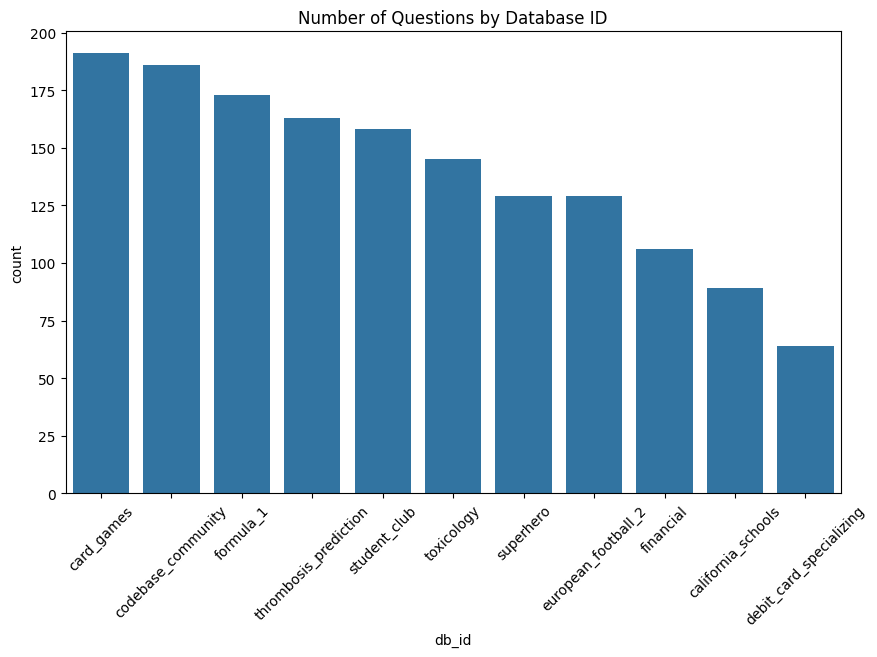

In [12]:
# Histogram Analysis - Distribution of Questions by `db_id`
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='db_id', order=df['db_id'].value_counts().index)
plt.title('Number of Questions by Database ID')
plt.xticks(rotation=45)
plt.show()

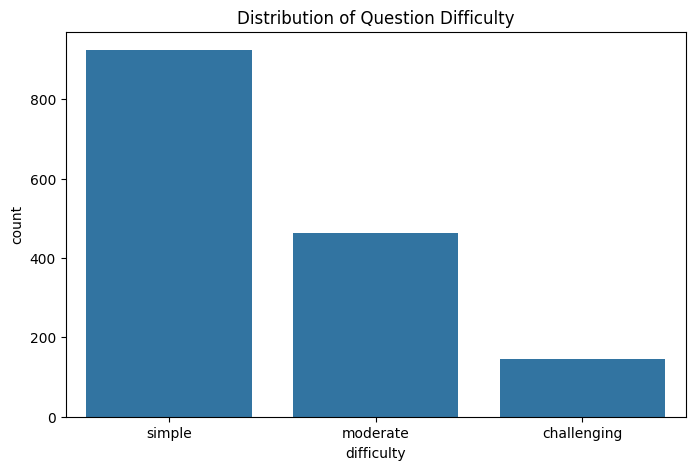

In [13]:
# Difficulty Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='difficulty', order=["simple", "moderate", "challenging"])
plt.title('Distribution of Question Difficulty')
plt.show()


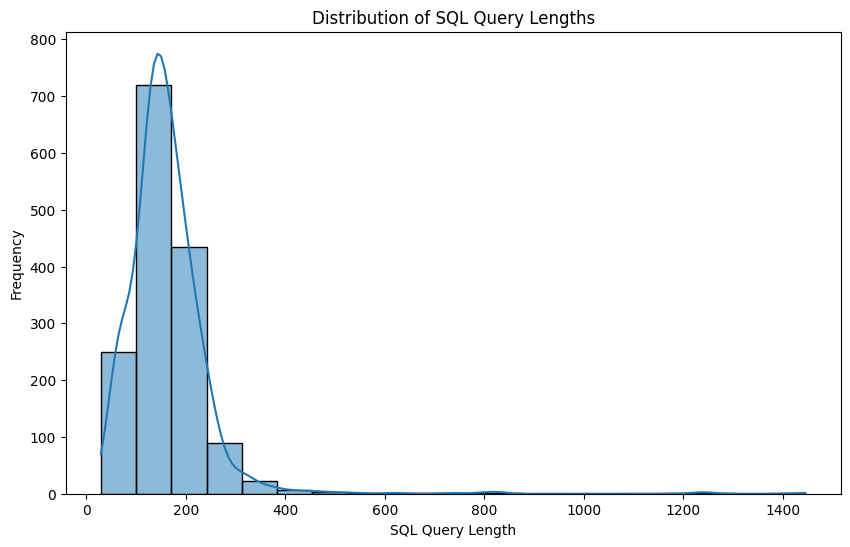

In [14]:
# SQL Length Analysis
plt.figure(figsize=(10, 6))
sns.histplot(df['sql_length'], bins=20, kde=True)
plt.title('Distribution of SQL Query Lengths')
plt.xlabel('SQL Query Length')
plt.ylabel('Frequency')
plt.show()

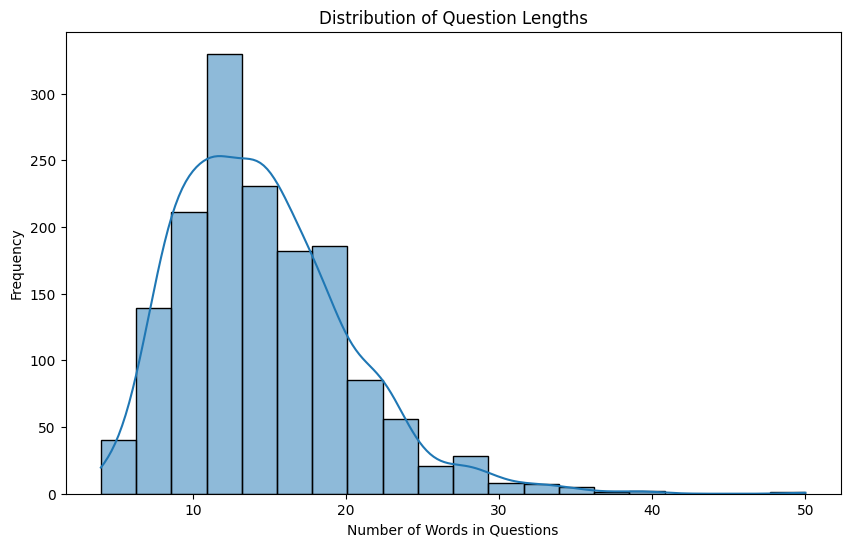

In [15]:
# Question Length Analysis
plt.figure(figsize=(10, 6))
sns.histplot(df['question_length'], bins=20, kde=True)
plt.title('Distribution of Question Lengths')
plt.xlabel('Number of Words in Questions')
plt.ylabel('Frequency')
plt.show()

In [16]:
# Normalize Length Features
# Normalize `question_length` and `sql_length`
df['question_length_norm'] = (df['question_length'] - df['question_length'].mean()) / df['question_length'].std()
df['sql_length_norm'] = (df['sql_length'] - df['sql_length'].mean()) / df['sql_length'].std()

# Display normalized features
df[['question_length_norm', 'sql_length_norm']].head()

,question_length_norm,sql_length_norm
0,0.258897,0.210309
1,0.079876,1.348060
2,0.258897,0.187554
3,0.616937,-0.324433
4,0.079876,0.437860


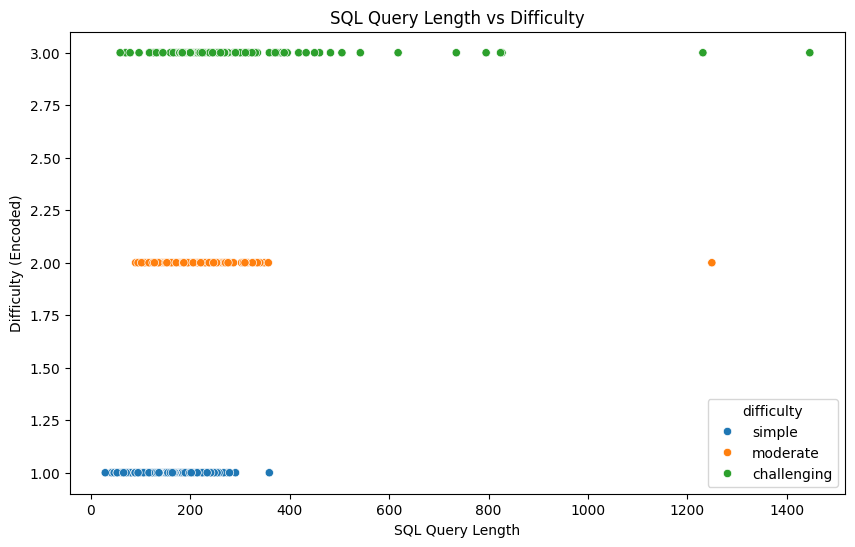

In [17]:
# Advanced Analysis - SQL Length vs Difficulty
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='sql_length', y='difficulty_encoded', hue='difficulty')
plt.title('SQL Query Length vs Difficulty')
plt.xlabel('SQL Query Length')
plt.ylabel('Difficulty (Encoded)')
plt.show()

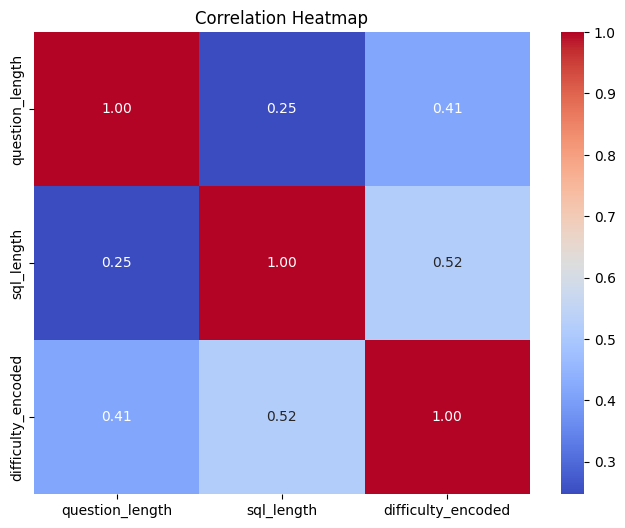

In [18]:
# Correlation Heatmap
# Compute correlation matrix
correlation_matrix = df[['question_length', 'sql_length', 'difficulty_encoded']].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [19]:
# Save Processed Dataset
# Save the processed dataset to a CSV file
df.to_csv("processed_dataset.csv", index=False)

# Confirm save
print("Processed dataset saved as 'processed_dataset.csv'.")

Processed dataset saved as 'processed_dataset.csv'.


In [22]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Assuming 'df' is your DataFrame and 'question' is the column with text data
# Step 1: Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words='english')

# Step 2: Fit and transform the 'question' field to create the TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(df['question'])

# Step 3: Convert sparse matrix to dense array for further analysis
tfidf_dense = tfidf_matrix.toarray()


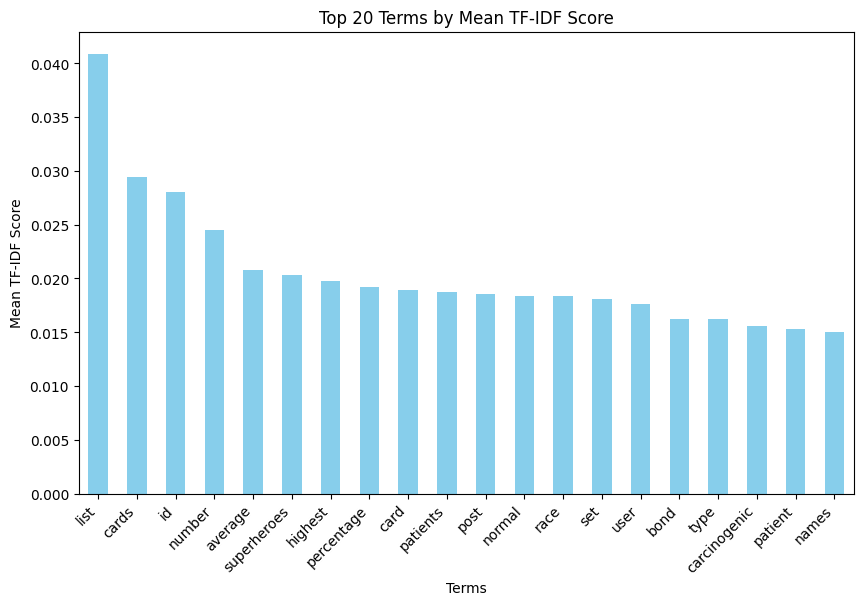

In [23]:
# Extract feature names and corresponding TF-IDF scores
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_dense_df = pd.DataFrame(tfidf_dense, columns=feature_names)

# Compute the mean TF-IDF score for each term
mean_tfidf_scores = tfidf_dense_df.mean(axis=0).sort_values(ascending=False)

# Visualize Top Terms using a Bar Chart
top_n = 20
top_terms = mean_tfidf_scores.head(top_n)

plt.figure(figsize=(10, 6))
top_terms.plot(kind='bar', color='skyblue')
plt.title(f'Top {top_n} Terms by Mean TF-IDF Score')
plt.xlabel('Terms')
plt.ylabel('Mean TF-IDF Score')
plt.xticks(rotation=45, ha='right')
plt.show()

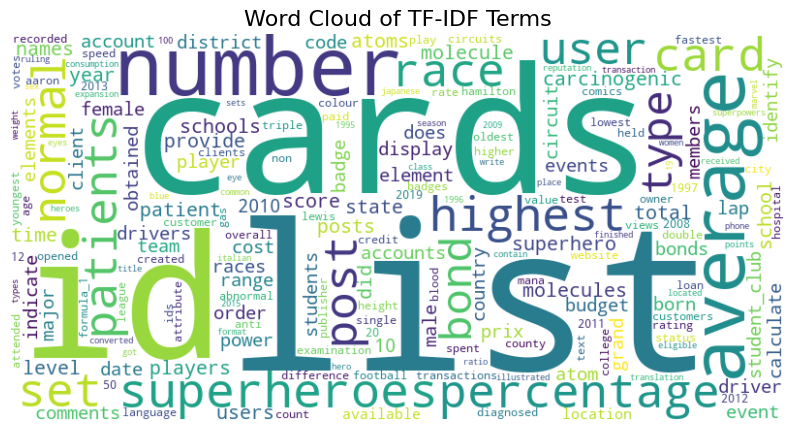

In [24]:
# Generate a word cloud from the mean TF-IDF scores
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(mean_tfidf_scores)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of TF-IDF Terms', fontsize=16)
plt.show()


In [26]:
print(wordcloud.words_)

{'list': 1.0, 'cards': 0.7194530983145827, 'id': 0.6857536063660006, 'number': 0.5999466011207643, 'average': 0.50872003532239, 'superheroes': 0.4972814848961081, 'highest': 0.481901483651524, 'percentage': 0.46946360535835996, 'card': 0.4615998499363491, 'patients': 0.45897024128784775, 'post': 0.45439949849839584, 'normal': 0.44897073937159815, 'race': 0.4481624394955114, 'set': 0.44096522258858806, 'user': 0.43097195190369547, 'bond': 0.39574586525057664, 'type': 0.395552436514833, 'carcinogenic': 0.38113873785885194, 'patient': 0.37486360957298237, 'names': 0.3680303033111306, 'state': 0.36109324603004495, 'total': 0.3569001179952168, 'molecules': 0.34575491848510964, 'molecule': 0.3395491649933474, 'level': 0.3343981204756496, 'users': 0.33386305538559635, 'score': 0.33107652247665065, 'atoms': 0.3222909001458782, 'did': 0.3185384502006591, 'superhero': 0.3155855438110563, 'school': 0.30223617124051005, 'posts': 0.2994238490684912, 'schools': 0.2909298163628672, 'time': 0.28245097

SQL Command Frequencies: Counter({'COUNT': 550, 'SUM': 251, 'AVG': 57, 'MAX': 32, 'Count': 26, 'MIN': 15, 'Max': 1, 'Min': 1})


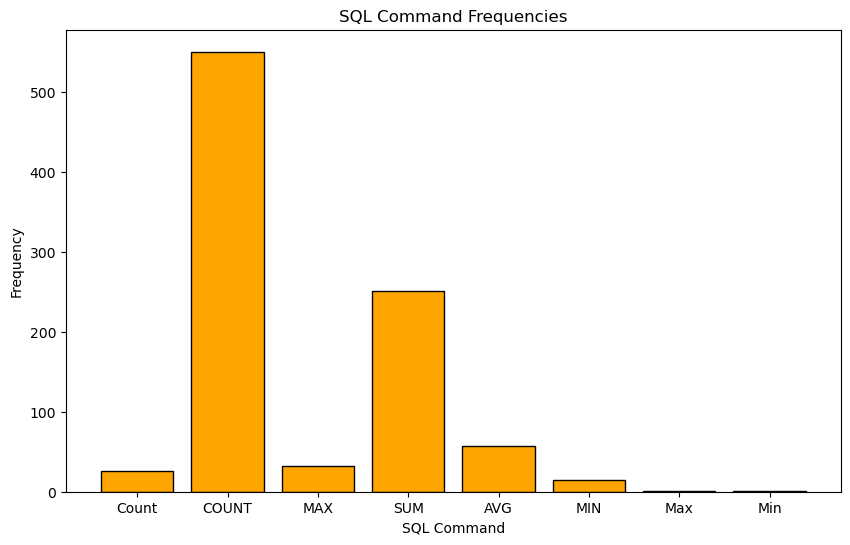

In [23]:
import re
from collections import Counter
import pandas as pd
import json

# Load dev.json dataset
file_path = "dev.json"
with open(file_path, "r") as f:
    dev_data = json.load(f)

# Extract SQL keywords, aggregates, and clauses
sql_keywords = ['SELECT', 'WHERE', 'FROM', 'ORDER BY', 'GROUP BY', 'HAVING', 'JOIN', 'INNER', 'LEFT', 'RIGHT']
aggregates = ['COUNT', 'SUM', 'AVG', 'MIN', 'MAX']

# Function to clean SQL and extract meaningful parts
def clean_sql(sql):
    # Remove SQL dialect keywords
    for keyword in sql_keywords:
        sql = re.sub(rf"\b{keyword}\b", "", sql, flags=re.IGNORECASE)
    return sql.strip()

# Extract SQL components
sql_commands = []
cleaned_sqls = []
for entry in dev_data:
    sql = entry["SQL"]
    cleaned_sql = clean_sql(sql)
    cleaned_sqls.append(cleaned_sql)
    
    # Extract commands
    commands = re.findall(rf"\b({'|'.join(aggregates)})\b", sql, flags=re.IGNORECASE)
    sql_commands.extend(commands)

# Frequency of SQL commands
sql_command_freq = Counter(sql_commands)
print("SQL Command Frequencies:", sql_command_freq)

import matplotlib.pyplot as plt

# Plot SQL command frequencies
plt.figure(figsize=(10, 6))
plt.bar(sql_command_freq.keys(), sql_command_freq.values(), color='orange', edgecolor='black')
plt.xlabel("SQL Command")
plt.ylabel("Frequency")
plt.title("SQL Command Frequencies")
plt.show()


In [24]:
from openai import OpenAI
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from dotenv import load_dotenv
import os

# Load OpenAI API key
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
model = "text-embedding-3-large"

# Function to get embeddings
def get_embedding(text, model=model):
    response = client.embeddings.create(input=text, model=model)
    return response.data

import tiktoken

def num_tokens_from_string(string: str, encoding_name: str = "cl100k_base") -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

def estimate_cost_from_tokens(num_tokens: int, model_name: str = "text-embedding-3-large") -> float:
    """Estimates the cost of using OpenAI API based on the number of tokens."""
    # Get the cost per token for the model
    cost_per_token = costs[model_name]
    # Calculate the total cost
    total_cost = num_tokens * cost_per_token
    return total_cost

# Estimate cost of embeddings
costs = {
    "text-embedding-3-small": 0.020 / 10**6,
    "text-embedding-3-large": 0.130 / 10**6,
    "ada v2": 0.100 / 10**6,
}

# # Generate embeddings for questions and cleaned SQL
questions = [entry["question"] for entry in dev_data]
# estimate cost
num_tokens = num_tokens_from_string(" ".join(questions + cleaned_sqls))
cost = estimate_cost_from_tokens(num_tokens)
print("Number of Tokens:", num_tokens)
print("Estimated Cost:", cost)

# Generate embeddings for questions and cleaned SQL
question_embeddings = get_embedding(questions)
sql_embeddings = get_embedding(cleaned_sqls)

Number of Tokens: 101578
Estimated Cost: 0.01320514


In [25]:
question_embeddings = [np.array(embedding.embedding) for embedding in question_embeddings]

In [26]:
sql_embeddings = [np.array(embedding.embedding) for embedding in sql_embeddings]

In [27]:
question_embeddings = np.array(question_embeddings)
sql_embeddings = np.array(sql_embeddings)

print("Shape of Question Embeddings:", question_embeddings.shape)
print("Shape of SQL Embeddings:", sql_embeddings.shape)


Shape of Question Embeddings: (1534, 3072)
Shape of SQL Embeddings: (1534, 3072)


Similarity Statistics:
Mean: 0.5429
Median: 0.5421
Min: 0.2344
Max: 0.8366
Average Similarity: 0.542858330809495


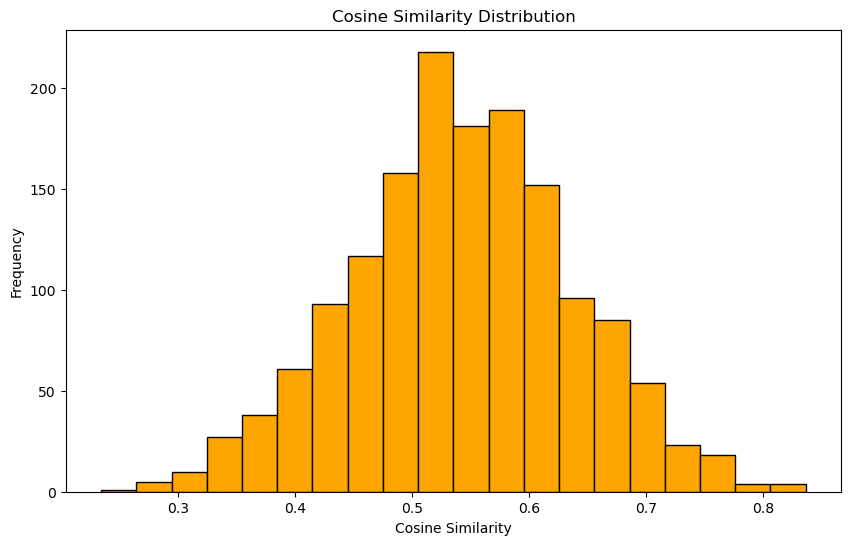

In [28]:
# Calculate cosine similarities
similarities = [
    cosine_similarity([q_embed], [sql_embed])[0][0]
    for q_embed, sql_embed in zip(question_embeddings, sql_embeddings)
]

# Analyze similarity statistics
import numpy as np
print("Similarity Statistics:")
print(f"Mean: {np.mean(similarities):.4f}")
print(f"Median: {np.median(similarities):.4f}")
print(f"Min: {np.min(similarities):.4f}")
print(f"Max: {np.max(similarities):.4f}")

# Average similarity
print("Average Similarity:", np.mean(similarities))

# Plot similarities
plt.figure(figsize=(10, 6))
plt.hist(similarities, bins=20, color='orange', edgecolor='black')
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Cosine Similarity Distribution")
plt.show()


Combined Embedding Shape: (3068, 3072)
Reduced Embedding Shape: (3068, 3)
Question Reduced Shape: (1534, 3)
SQL Reduced Shape: (1534, 3)
Question Embeddings Min/Max: -0.41294907700953193 0.5136819655024135
SQL Embeddings Min/Max: -0.44103114357631473 0.46590360011443616


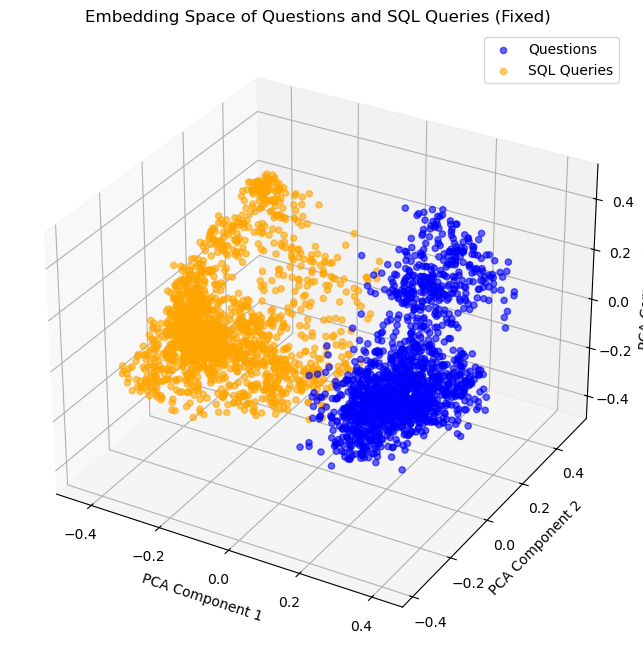

In [29]:
import numpy as np
from sklearn.decomposition import PCA

# Combine embeddings properly for PCA
all_embeddings = np.vstack([question_embeddings, sql_embeddings])

# Verify combined embedding shape
print("Combined Embedding Shape:", all_embeddings.shape)

# Apply PCA
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(all_embeddings)

# Split reduced embeddings back into questions and SQL
question_reduced = reduced_embeddings[:len(question_embeddings)]
sql_reduced = reduced_embeddings[len(question_embeddings):]

# Debugging: Check shapes and values
print("Reduced Embedding Shape:", reduced_embeddings.shape)
print("Question Reduced Shape:", question_reduced.shape)
print("SQL Reduced Shape:", sql_reduced.shape)
print("Question Embeddings Min/Max:", question_reduced.min(), question_reduced.max())
print("SQL Embeddings Min/Max:", sql_reduced.min(), sql_reduced.max())

# 3D Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for questions and SQL
ax.scatter(question_reduced[:, 0], question_reduced[:, 1], question_reduced[:, 2], label='Questions', alpha=0.6, color='blue', s=20)
ax.scatter(sql_reduced[:, 0], sql_reduced[:, 1], sql_reduced[:, 2], label='SQL Queries', alpha=0.6, color='orange', s=20)

# Set plot labels and title
ax.set_title("Embedding Space of Questions and SQL Queries (Fixed)")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.legend()
plt.show()

Combined Embedding Shape: (3068, 3072)
Reduced Embedding Shape: (3068, 3)
Question Reduced Shape: (1534, 3)
SQL Reduced Shape: (1534, 3)
Question Embeddings Min/Max: -0.4129464660834777 0.5136811251662646
SQL Embeddings Min/Max: -0.44103117104608636 0.4659068654680399


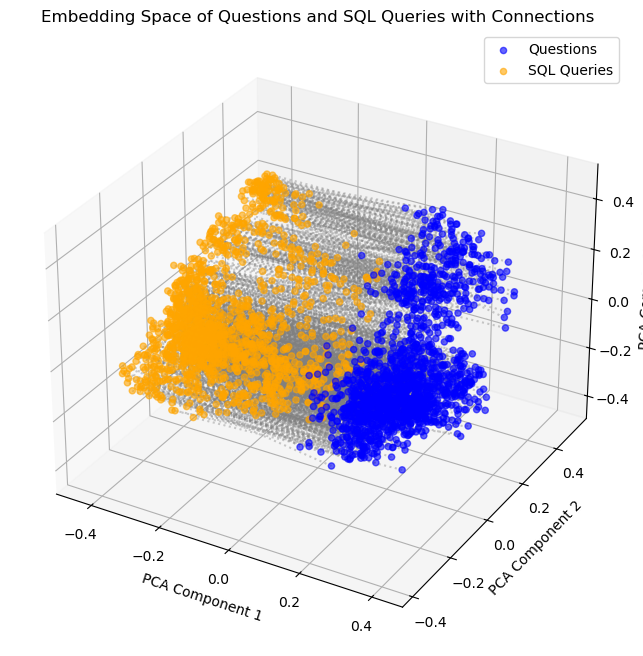

In [30]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Combine embeddings properly for PCA
all_embeddings = np.vstack([question_embeddings, sql_embeddings])

# Verify combined embedding shape
print("Combined Embedding Shape:", all_embeddings.shape)

# Apply PCA
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(all_embeddings)

# Split reduced embeddings back into questions and SQL
question_reduced = reduced_embeddings[:len(question_embeddings)]
sql_reduced = reduced_embeddings[len(question_embeddings):]

# Debugging: Check shapes and values
print("Reduced Embedding Shape:", reduced_embeddings.shape)
print("Question Reduced Shape:", question_reduced.shape)
print("SQL Reduced Shape:", sql_reduced.shape)
print("Question Embeddings Min/Max:", question_reduced.min(), question_reduced.max())
print("SQL Embeddings Min/Max:", sql_reduced.min(), sql_reduced.max())

# 3D Visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for questions and SQL
ax.scatter(question_reduced[:, 0], question_reduced[:, 1], question_reduced[:, 2], label='Questions', alpha=0.6, color='blue', s=20)
ax.scatter(sql_reduced[:, 0], sql_reduced[:, 1], sql_reduced[:, 2], label='SQL Queries', alpha=0.6, color='orange', s=20)

# Draw lines connecting question and SQL pairs
for q, s in zip(question_reduced, sql_reduced):
    ax.plot(
        [q[0], s[0]], [q[1], s[1]], [q[2], s[2]],
        color='gray', alpha=0.4, linestyle='dotted'
    )

# Set plot labels and title
ax.set_title("Embedding Space of Questions and SQL Queries with Connections")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.legend()
plt.show()

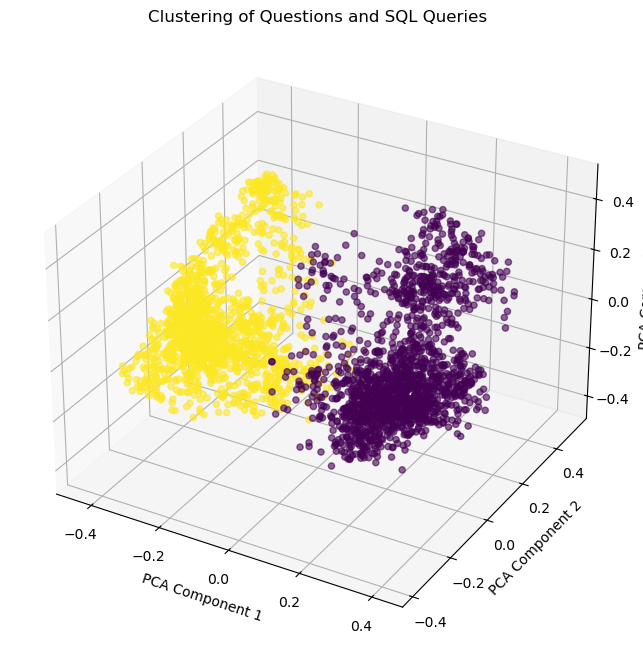

In [31]:
from sklearn.cluster import KMeans

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(reduced_embeddings)

# Visualize clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    reduced_embeddings[:, 0], reduced_embeddings[:, 1], reduced_embeddings[:, 2],
    c=clusters, cmap='viridis', alpha=0.6
)

ax.set_title("Clustering of Questions and SQL Queries")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
plt.show()

In [32]:
import pandas as pd

# Combine questions and similarities into a DataFrame
data = pd.DataFrame({
    "question": [entry["question"] for entry in dev_data],
    "similarity": similarities,
    "difficulty": [entry["difficulty"] for entry in dev_data]
})

# Analyze similarity by difficulty level
print(data.groupby("difficulty")["similarity"].describe())

             count      mean       std       min       25%       50%  \
difficulty                                                             
challenging  145.0  0.527998  0.080722  0.333098  0.481997  0.532274   
moderate     464.0  0.531711  0.090414  0.234423  0.472644  0.533095   
simple       925.0  0.550780  0.098178  0.285779  0.487139  0.548648   

                  75%       max  
difficulty                       
challenging  0.585768  0.695281  
moderate     0.588643  0.816061  
simple       0.612858  0.836562  


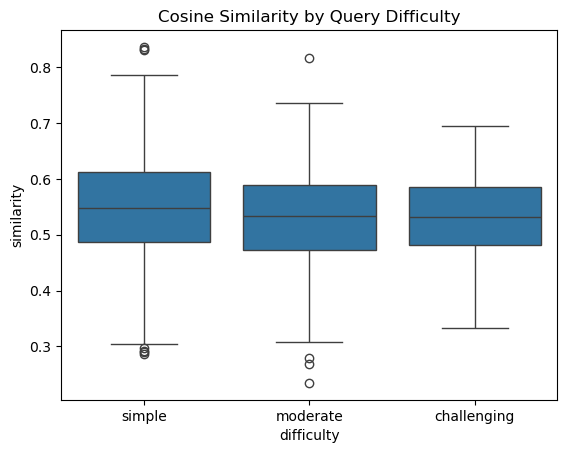

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot similarity scores by difficulty
sns.boxplot(x="difficulty", y="similarity", data=data)
plt.title("Cosine Similarity by Query Difficulty")
plt.show()